## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum-Classical Neural Networks and Classical Convolutional Neural Networks on the G1020 dataset. The G1020 dataset is a glaucoma-focused dataset with 1020 fundus images. The dataset was produced in Germany and is labeled with binary classification (Non-Glaucoma and Glaucoma).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 91.5 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-G1020_models/"

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)


  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)
            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)


    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)


    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')


    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')


    hybrid_aucs = []
    normal_aucs = []

    if num_classes == 2:

        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)


        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curve for the Normal Model
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()



        print("\nHybrid Model Metrics:")
        print(f'Accuracy: {accuracy_hybrid:.4f}')
        print(f'F1 Score: {f1_hybrid:.4f}')
        print(f'Precision: {precision_hybrid:.4f}')
        print(f'Recall: {recall_hybrid:.4f}')
        print(f'AUROC: {auc_hybrid}')

        print("\nNormal Model Metrics:")
        print(f'Accuracy: {accuracy_normal:.4f}')
        print(f'F1 Score: {f1_normal:.4f}')
        print(f'Precision: {precision_normal:.4f}')
        print(f'Recall: {recall_normal:.4f}')
        print(f'AUROC: {auc_normal} \n')

        cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {auc_hybrid})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        cm_normal = confusion_matrix(all_labels, all_preds_normal)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {auc_normal})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()


    else:  # Multi-class Classification

        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

        # Define a color cycle for plotting
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        # Plot ROC curves for the Hybrid Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Hybrid Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curves for the Normal Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Normal Model')
        plt.legend(loc='lower right')
        plt.show()



        normal_auc = f"{sum(normal_aucs) / len(normal_aucs):.4f}"
        hybrid_auc = f"{sum(hybrid_aucs) / len(hybrid_aucs):.4f}"

        print("\nHybrid Model Metrics:")
        print(f'Accuracy: {accuracy_hybrid:.4f}')
        print(f'F1 Score: {f1_hybrid:.4f}')
        print(f'Precision: {precision_hybrid:.4f}')
        print(f'Recall: {recall_hybrid:.4f}')
        print(f'AUROC: {hybrid_auc}')

        print("\nNormal Model Metrics:")
        print(f'Accuracy: {accuracy_normal:.4f}')
        print(f'F1 Score: {f1_normal:.4f}')
        print(f'Precision: {precision_normal:.4f}')
        print(f'Recall: {recall_normal:.4f}')
        print(f'AUROC: {normal_auc} \n')

        cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        cm_normal = confusion_matrix(all_labels, all_preds_normal)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

### Classical Resnet-18 Construction

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### Hybrid Quantum-Classical Resnet-18 Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

# Experiments

In [ ]:
n_epochs = 100
num_classes = 2
batch_size = 32
dataset = "G1020"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
q_depth = 4

## Seed Experiment 1

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=2)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 57:


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7085, Training Accuracy: 70.05%, Training AUROC: 0.5214
Validation Loss: 0.6254, Validation Accuracy: 71.05%, Validation AUROC: 0.4697
Epoch [2/100]
Training Loss: 0.6749, Training Accuracy: 65.24%, Training AUROC: 0.5334
Validation Loss: 0.6705, Validation Accuracy: 66.45%, Validation AUROC: 0.4865
Epoch [3/100]
Training Loss: 0.6492, Training Accuracy: 65.06%, Training AUROC: 0.5525
Validation Loss: 0.6691, Validation Accuracy: 68.42%, Validation AUROC: 0.4693
Epoch [4/100]
Training Loss: 0.6513, Training Accuracy: 67.02%, Training AUROC: 0.5395
Validation Loss: 0.6678, Validation Accuracy: 68.42%, Validation AUROC: 0.4674
Epoch [5/100]
Training Loss: 0.6312, Training Accuracy: 68.09%, Training AUROC: 0.5713
Validation Loss: 0.6670, Validation Accuracy: 69.08%, Validation AUROC: 0.4710
Epoch [6/100]
Training Loss: 0.6560, Training Accuracy: 65.24%, Training AUROC: 0.5391
Validation Loss: 0.6601, Validation Accuracy: 69.74%, Validation AUROC: 0.4649
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6898, Training Accuracy: 54.01%, Training AUROC: 0.4949
Validation Loss: 0.6985, Validation Accuracy: 36.18%, Validation AUROC: 0.5101
Epoch [2/100]
Training Loss: 0.6554, Training Accuracy: 64.35%, Training AUROC: 0.5214
Validation Loss: 0.6890, Validation Accuracy: 54.61%, Validation AUROC: 0.4816
Epoch [3/100]
Training Loss: 0.6328, Training Accuracy: 70.23%, Training AUROC: 0.5027
Validation Loss: 0.6782, Validation Accuracy: 63.16%, Validation AUROC: 0.4754
Epoch [4/100]
Training Loss: 0.6226, Training Accuracy: 70.94%, Training AUROC: 0.4820
Validation Loss: 0.6643, Validation Accuracy: 71.05%, Validation AUROC: 0.4725
Epoch [5/100]
Training Loss: 0.6168, Training Accuracy: 70.94%, Training AUROC: 0.5307
Validation Loss: 0.6626, Validation Accuracy: 71.05%, Validation AUROC: 0.4598
Epoch [6/100]
Training Loss: 0.6143, Training Accuracy: 70.94%, Training AUROC: 0.4573
Validation Loss: 0.6548, Validation Accuracy: 71.05%, Validation AUROC: 0.4630
Epoc

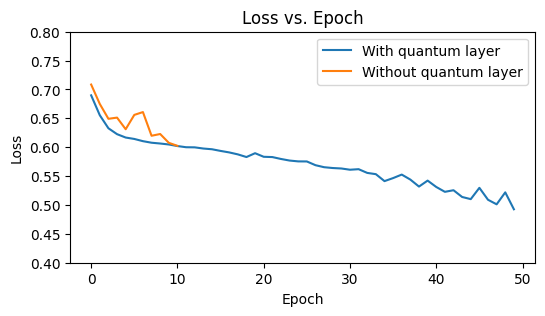

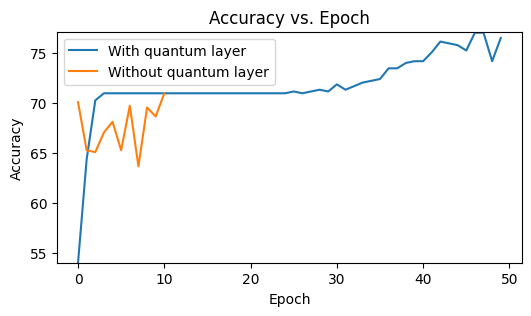

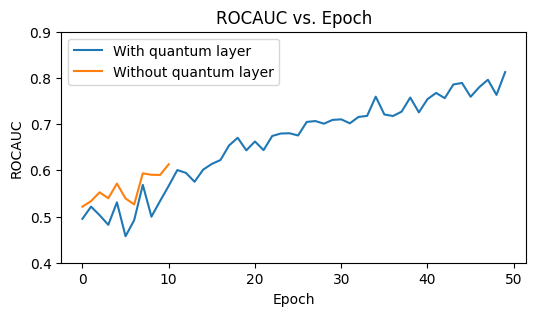

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

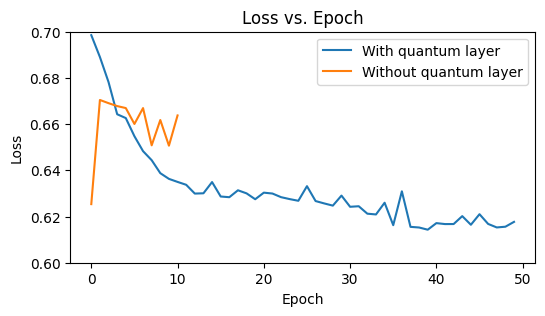

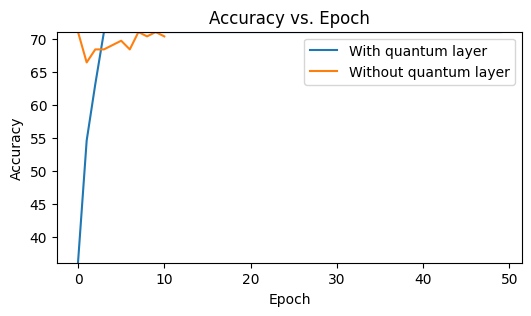

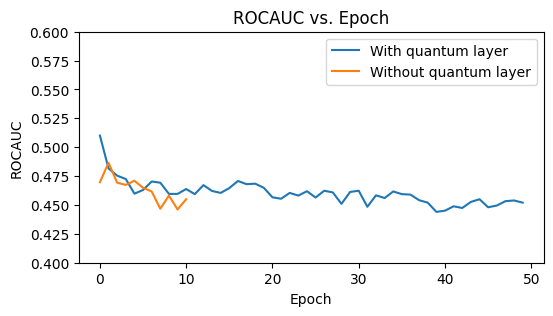

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


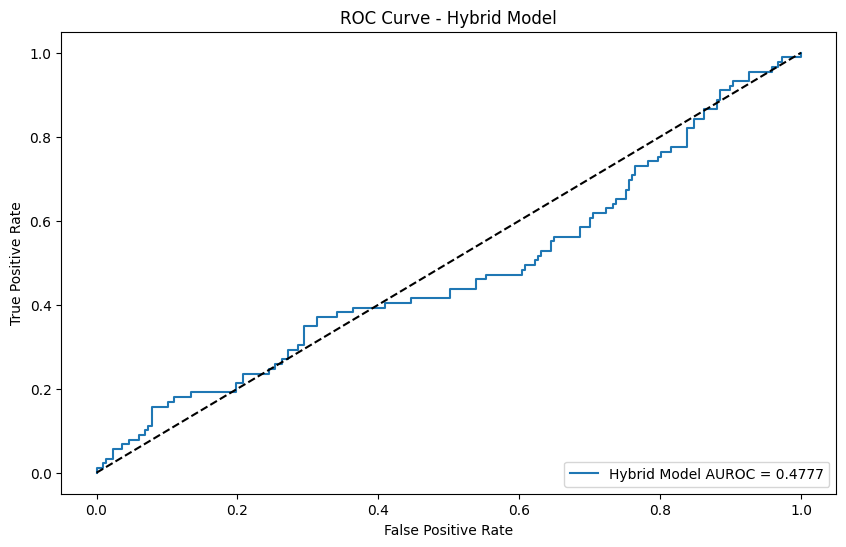

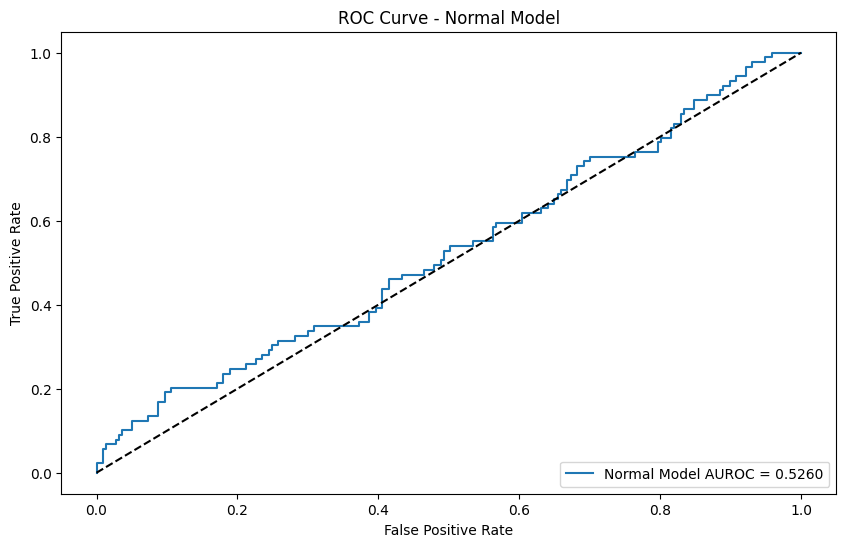


Hybrid Model Metrics:
Accuracy: 0.7092
F1 Score: 0.5885
Precision: 0.0000
Recall: 0.0000
AUROC: 0.47770931496919167

Normal Model Metrics:
Accuracy: 0.7124
F1 Score: 0.5961
Precision: 1.0000
Recall: 0.0112
AUROC: 0.5260187438512919 



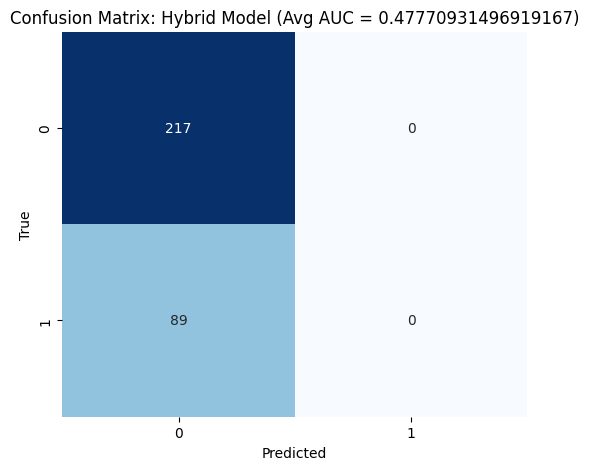

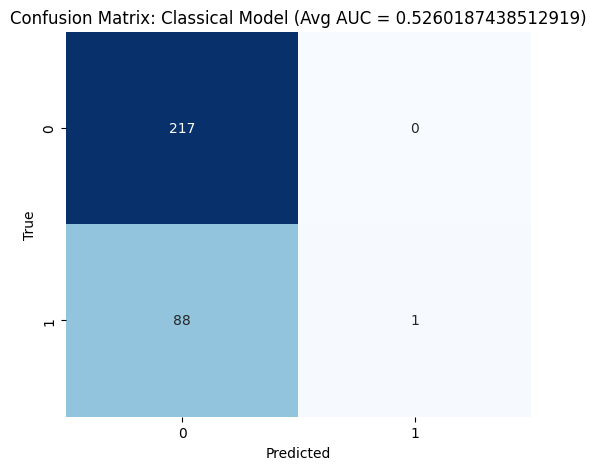

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=2)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 6:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7332, Training Accuracy: 57.22%, Training AUROC: 0.5113
Validation Loss: 0.6594, Validation Accuracy: 71.05%, Validation AUROC: 0.5398
Epoch [2/100]
Training Loss: 0.6763, Training Accuracy: 64.88%, Training AUROC: 0.5337
Validation Loss: 0.6771, Validation Accuracy: 63.16%, Validation AUROC: 0.5596
Epoch [3/100]
Training Loss: 0.6745, Training Accuracy: 65.95%, Training AUROC: 0.5363
Validation Loss: 0.6903, Validation Accuracy: 50.66%, Validation AUROC: 0.5633
Epoch [4/100]
Training Loss: 0.6999, Training Accuracy: 62.75%, Training AUROC: 0.4923
Validation Loss: 0.6931, Validation Accuracy: 49.34%, Validation AUROC: 0.5516
Epoch [5/100]
Training Loss: 0.6735, Training Accuracy: 66.84%, Training AUROC: 0.5275
Validation Loss: 0.6873, Validation Accuracy: 55.92%, Validation AUROC: 0.5450
Epoch [6/100]
Training Loss: 0.6531, Training Accuracy: 67.74%, Training AUROC: 0.5459
Validation Loss: 0.6810, Validation Accuracy: 60.53%, Validation AUROC: 0.5349
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9523, Training Accuracy: 33.33%, Training AUROC: 0.5068
Validation Loss: 0.7563, Validation Accuracy: 28.95%, Validation AUROC: 0.5309
Epoch [2/100]
Training Loss: 0.7483, Training Accuracy: 50.62%, Training AUROC: 0.5298
Validation Loss: 0.6967, Validation Accuracy: 50.66%, Validation AUROC: 0.5404
Epoch [3/100]
Training Loss: 0.6456, Training Accuracy: 65.42%, Training AUROC: 0.4881
Validation Loss: 0.6734, Validation Accuracy: 59.21%, Validation AUROC: 0.4994
Epoch [4/100]
Training Loss: 0.6180, Training Accuracy: 70.05%, Training AUROC: 0.5236
Validation Loss: 0.6623, Validation Accuracy: 69.74%, Validation AUROC: 0.4956
Epoch [5/100]
Training Loss: 0.6145, Training Accuracy: 70.77%, Training AUROC: 0.4978
Validation Loss: 0.6618, Validation Accuracy: 71.05%, Validation AUROC: 0.4886
Epoch [6/100]
Training Loss: 0.6159, Training Accuracy: 70.41%, Training AUROC: 0.5068
Validation Loss: 0.6642, Validation Accuracy: 69.74%, Validation AUROC: 0.4857
Epoc

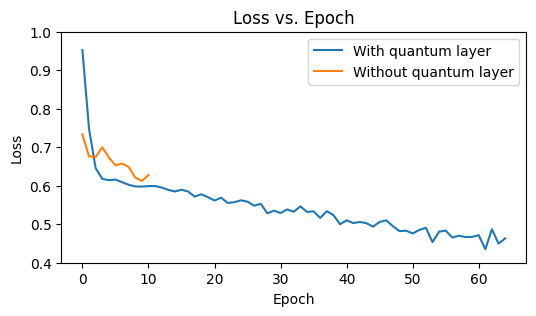

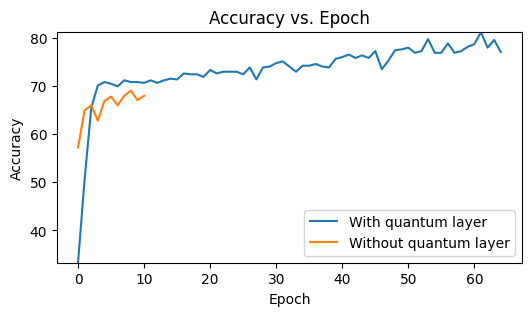

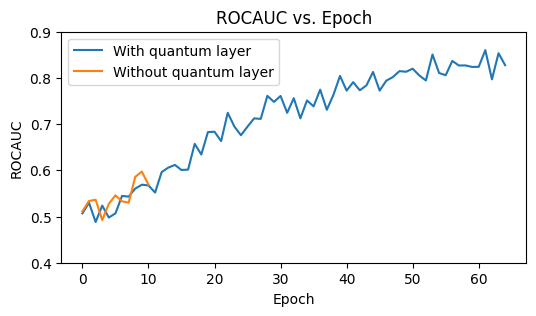

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

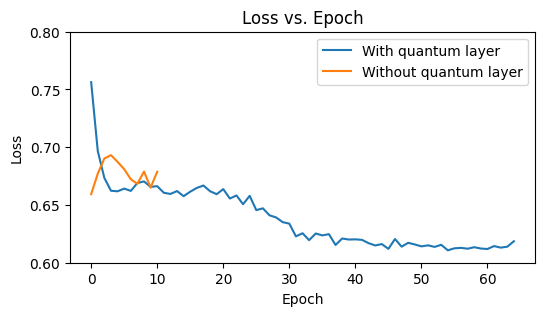

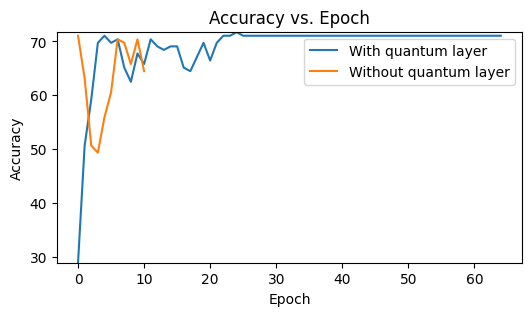

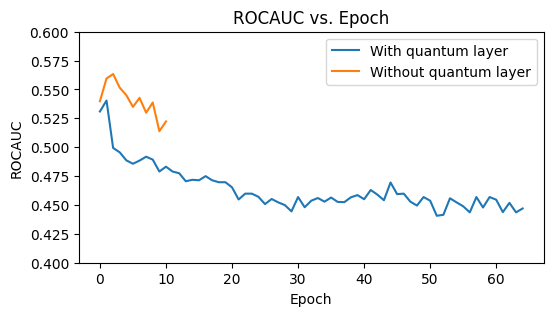

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


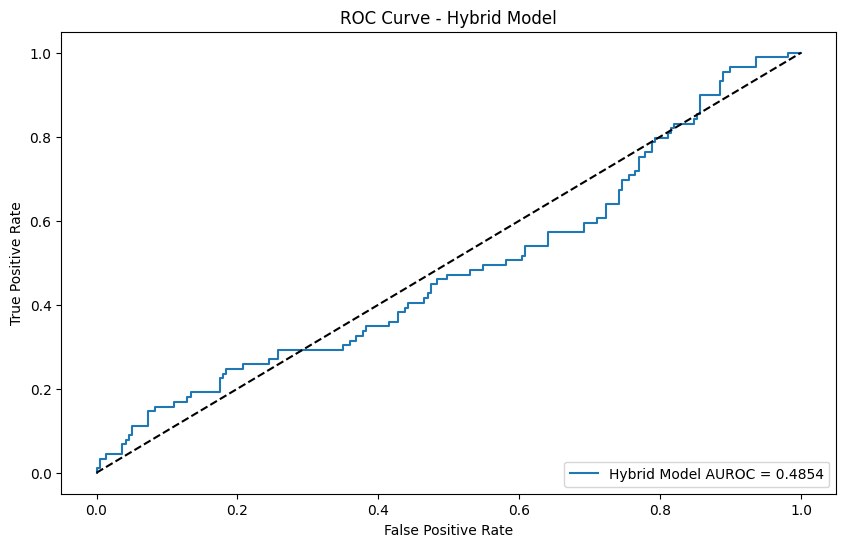

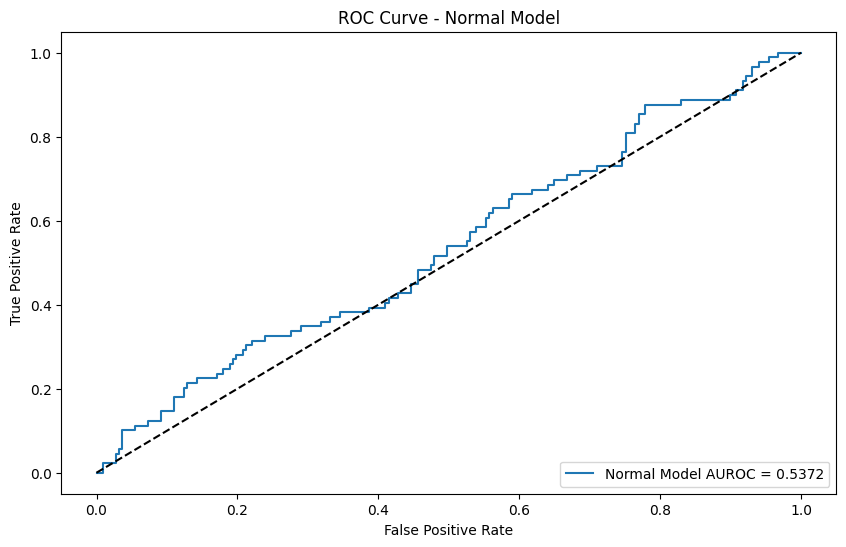


Hybrid Model Metrics:
Accuracy: 0.7092
F1 Score: 0.5885
Precision: 0.0000
Recall: 0.0000
AUROC: 0.4854243255838036

Normal Model Metrics:
Accuracy: 0.6765
F1 Score: 0.6255
Precision: 0.3611
Recall: 0.1461
AUROC: 0.5371511417180138 



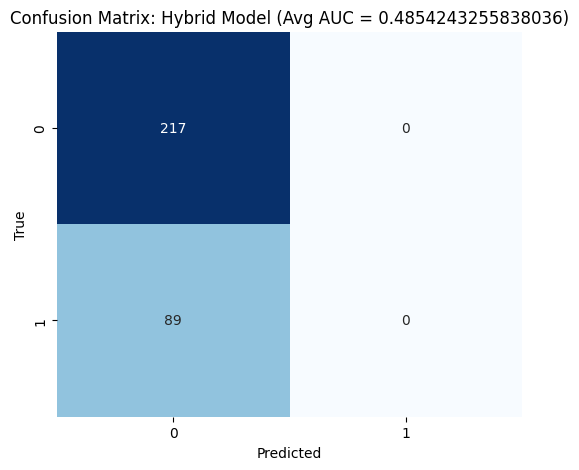

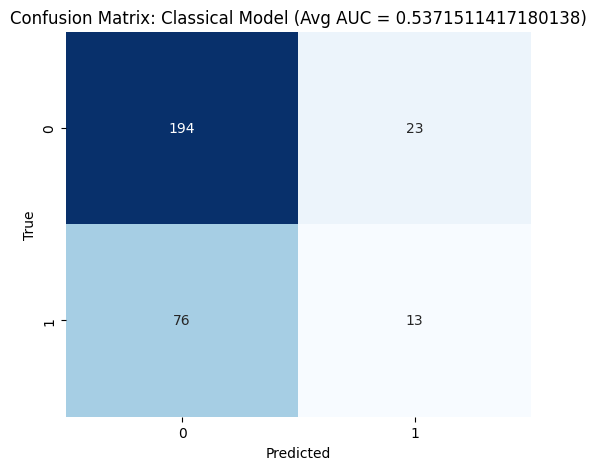

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=2)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 74:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.8026, Training Accuracy: 51.34%, Training AUROC: 0.5172
Validation Loss: 0.7156, Validation Accuracy: 42.76%, Validation AUROC: 0.5265
Epoch [2/100]
Training Loss: 0.7017, Training Accuracy: 62.21%, Training AUROC: 0.5039
Validation Loss: 0.6583, Validation Accuracy: 70.39%, Validation AUROC: 0.5053
Epoch [3/100]
Training Loss: 0.7091, Training Accuracy: 67.56%, Training AUROC: 0.5114
Validation Loss: 0.6571, Validation Accuracy: 70.39%, Validation AUROC: 0.5311
Epoch [4/100]
Training Loss: 0.6910, Training Accuracy: 63.81%, Training AUROC: 0.5061
Validation Loss: 0.6610, Validation Accuracy: 69.74%, Validation AUROC: 0.5423
Epoch [5/100]
Training Loss: 0.6729, Training Accuracy: 66.13%, Training AUROC: 0.5277
Validation Loss: 0.6539, Validation Accuracy: 70.39%, Validation AUROC: 0.5467
Epoch [6/100]
Training Loss: 0.6708, Training Accuracy: 65.60%, Training AUROC: 0.5155
Validation Loss: 0.6603, Validation Accuracy: 70.39%, Validation AUROC: 0.5444
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7286, Training Accuracy: 49.20%, Training AUROC: 0.4993
Validation Loss: 0.7804, Validation Accuracy: 28.95%, Validation AUROC: 0.4924
Epoch [2/100]
Training Loss: 0.6613, Training Accuracy: 63.81%, Training AUROC: 0.4505
Validation Loss: 0.7535, Validation Accuracy: 29.61%, Validation AUROC: 0.5082
Epoch [3/100]
Training Loss: 0.6249, Training Accuracy: 69.70%, Training AUROC: 0.4697
Validation Loss: 0.7212, Validation Accuracy: 37.50%, Validation AUROC: 0.4781
Epoch [4/100]
Training Loss: 0.6208, Training Accuracy: 70.59%, Training AUROC: 0.4632
Validation Loss: 0.7115, Validation Accuracy: 38.16%, Validation AUROC: 0.4773
Epoch [5/100]
Training Loss: 0.6130, Training Accuracy: 70.94%, Training AUROC: 0.4845
Validation Loss: 0.7049, Validation Accuracy: 39.47%, Validation AUROC: 0.4670
Epoch [6/100]
Training Loss: 0.6101, Training Accuracy: 70.77%, Training AUROC: 0.4815
Validation Loss: 0.7030, Validation Accuracy: 40.13%, Validation AUROC: 0.4646
Epoc

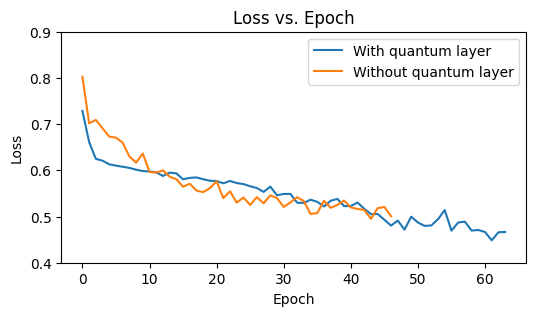

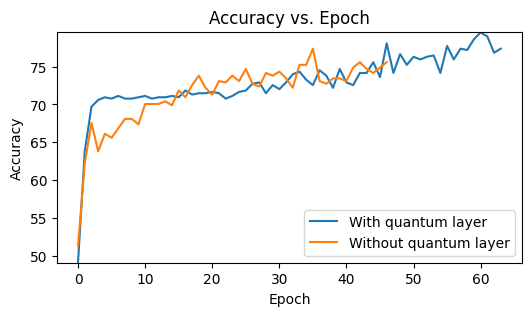

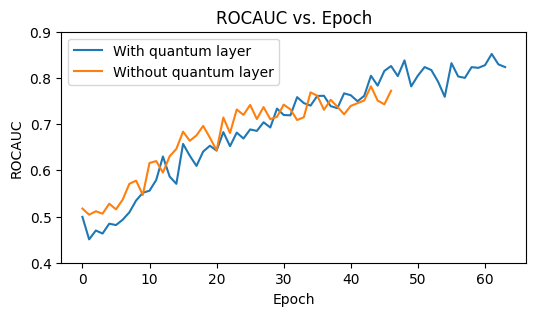

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

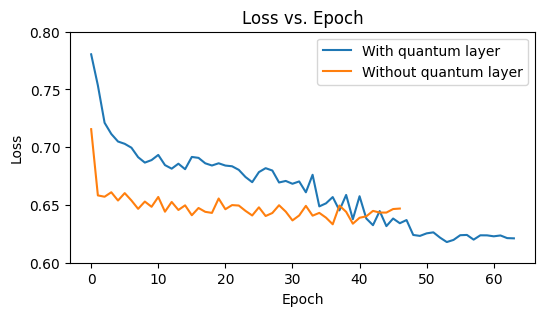

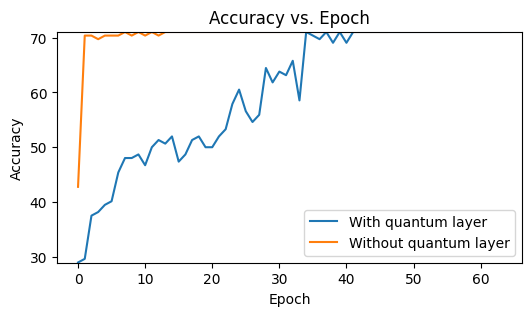

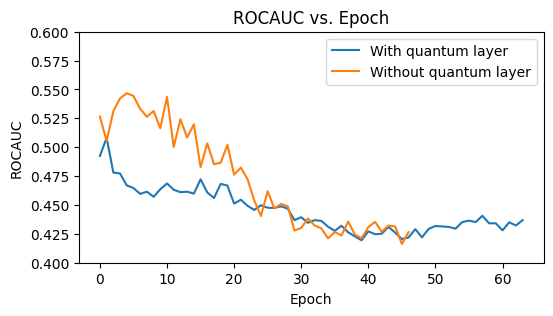

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


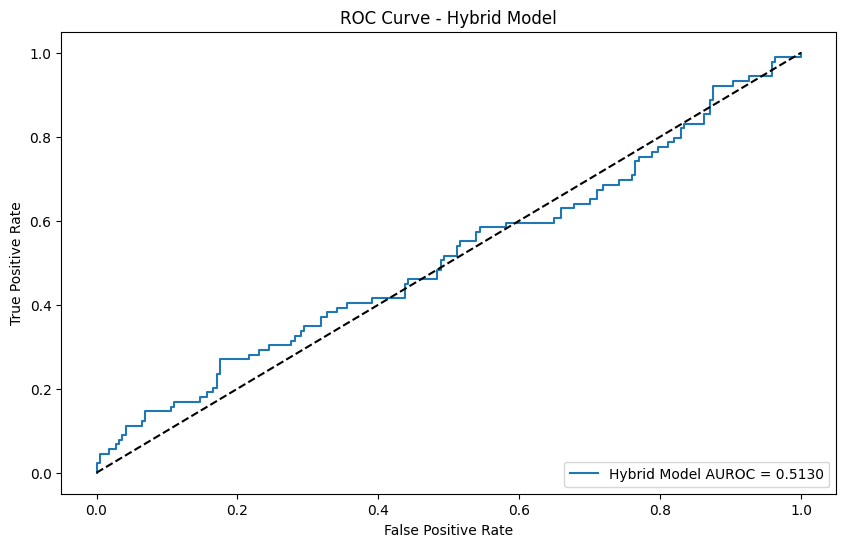

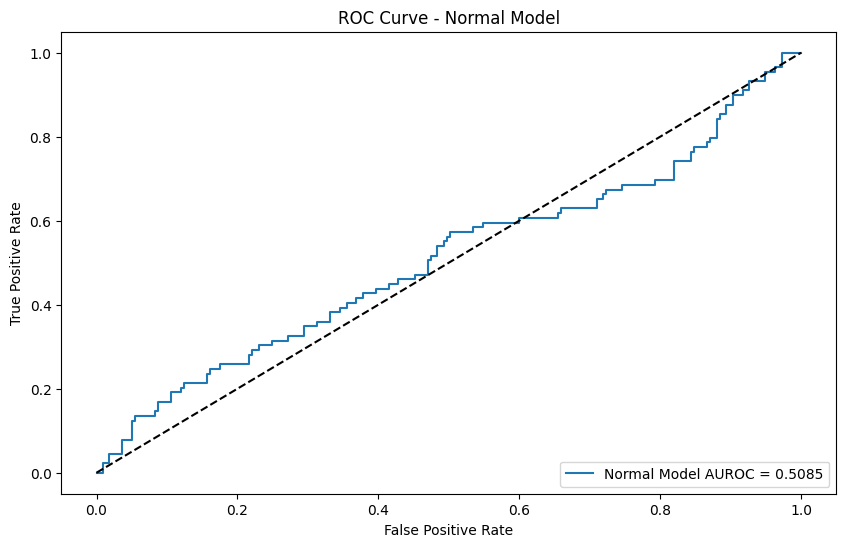


Hybrid Model Metrics:
Accuracy: 0.7092
F1 Score: 0.5885
Precision: 0.0000
Recall: 0.0000
AUROC: 0.5129705379795992

Normal Model Metrics:
Accuracy: 0.7092
F1 Score: 0.5885
Precision: 0.0000
Recall: 0.0000
AUROC: 0.5085175788329105 



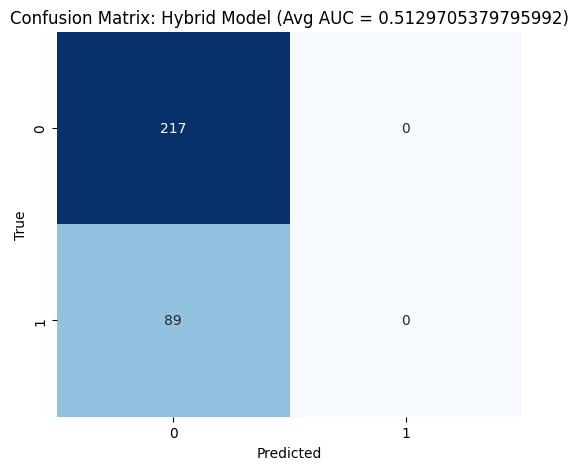

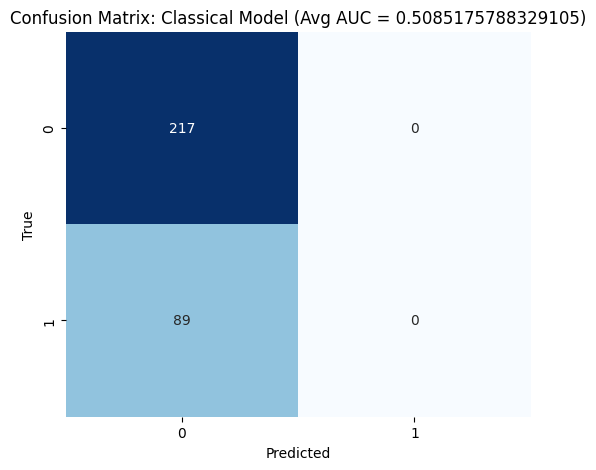

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 4

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=2)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 79:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7382, Training Accuracy: 55.44%, Training AUROC: 0.4963
Validation Loss: 0.6677, Validation Accuracy: 63.82%, Validation AUROC: 0.5339
Epoch [2/100]
Training Loss: 0.7187, Training Accuracy: 65.24%, Training AUROC: 0.4899
Validation Loss: 0.6843, Validation Accuracy: 54.61%, Validation AUROC: 0.4973
Epoch [3/100]
Training Loss: 0.7181, Training Accuracy: 64.17%, Training AUROC: 0.4765
Validation Loss: 0.6941, Validation Accuracy: 48.68%, Validation AUROC: 0.5025
Epoch [4/100]
Training Loss: 0.6847, Training Accuracy: 65.06%, Training AUROC: 0.5187
Validation Loss: 0.6961, Validation Accuracy: 48.68%, Validation AUROC: 0.5055
Epoch [5/100]
Training Loss: 0.6829, Training Accuracy: 64.17%, Training AUROC: 0.5023
Validation Loss: 0.6919, Validation Accuracy: 46.71%, Validation AUROC: 0.4935
Epoch [6/100]
Training Loss: 0.6633, Training Accuracy: 64.35%, Training AUROC: 0.5310
Validation Loss: 0.6893, Validation Accuracy: 52.63%, Validation AUROC: 0.4973
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6768, Training Accuracy: 58.65%, Training AUROC: 0.4707
Validation Loss: 0.6286, Validation Accuracy: 71.05%, Validation AUROC: 0.4758
Epoch [2/100]
Training Loss: 0.6268, Training Accuracy: 68.09%, Training AUROC: 0.5273
Validation Loss: 0.6385, Validation Accuracy: 69.74%, Validation AUROC: 0.5042
Epoch [3/100]
Training Loss: 0.6406, Training Accuracy: 68.81%, Training AUROC: 0.4627
Validation Loss: 0.6312, Validation Accuracy: 69.74%, Validation AUROC: 0.5076
Epoch [4/100]
Training Loss: 0.6243, Training Accuracy: 69.70%, Training AUROC: 0.5019
Validation Loss: 0.6362, Validation Accuracy: 69.74%, Validation AUROC: 0.5000
Epoch [5/100]
Training Loss: 0.6141, Training Accuracy: 71.12%, Training AUROC: 0.4947
Validation Loss: 0.6365, Validation Accuracy: 69.74%, Validation AUROC: 0.5036
Epoch [6/100]
Training Loss: 0.6071, Training Accuracy: 70.41%, Training AUROC: 0.5317
Validation Loss: 0.6343, Validation Accuracy: 69.74%, Validation AUROC: 0.5053
Epoc

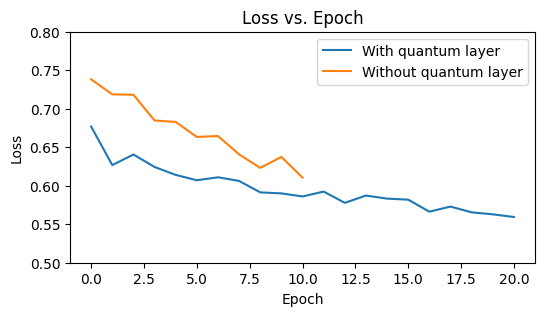

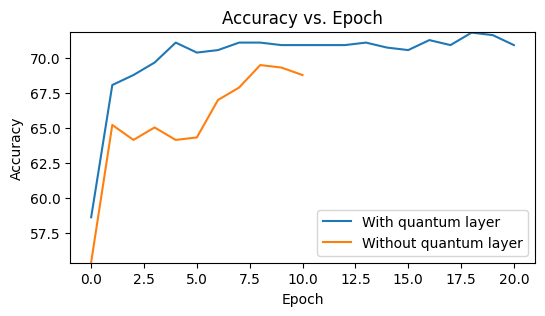

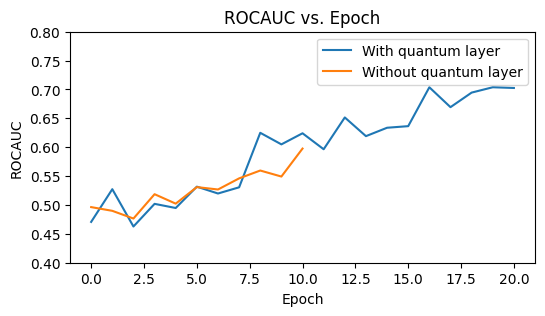

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

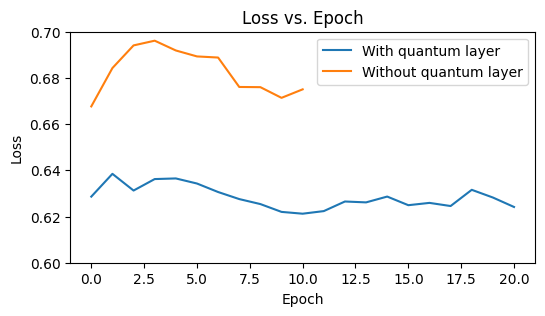

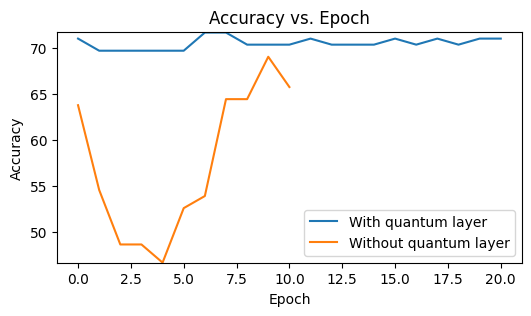

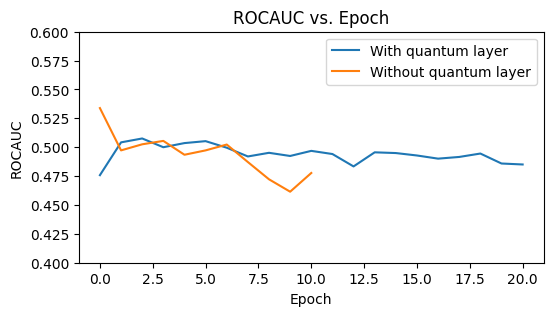

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

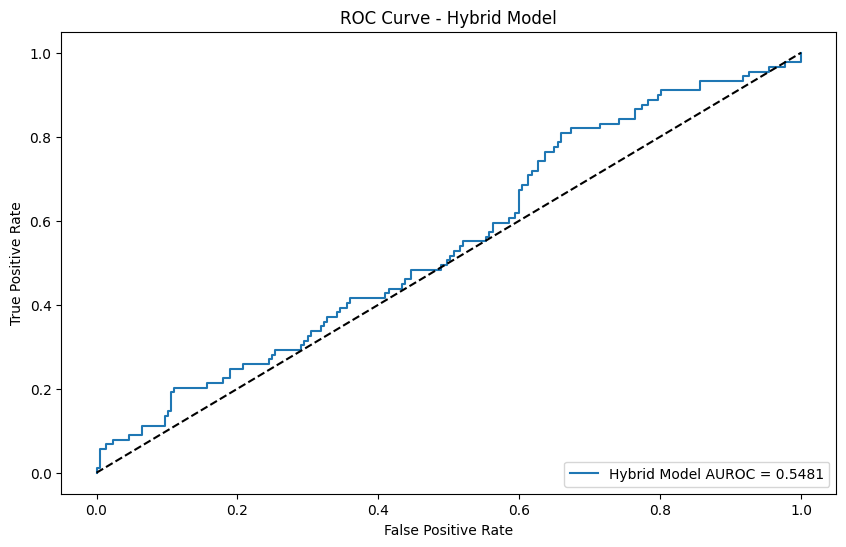

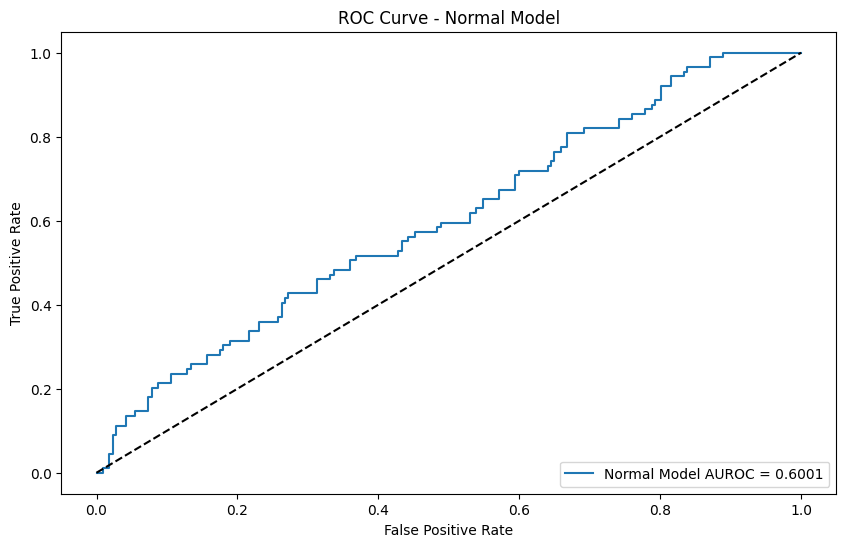


Hybrid Model Metrics:
Accuracy: 0.7124
F1 Score: 0.5961
Precision: 1.0000
Recall: 0.0112
AUROC: 0.5481282038005488

Normal Model Metrics:
Accuracy: 0.7092
F1 Score: 0.6155
Precision: 0.5000
Recall: 0.0562
AUROC: 0.6001139129084037 



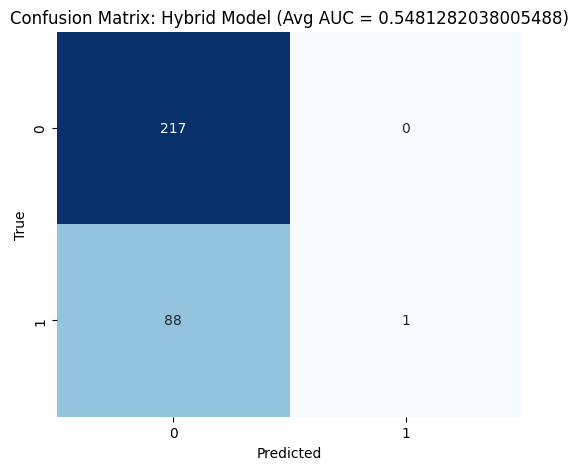

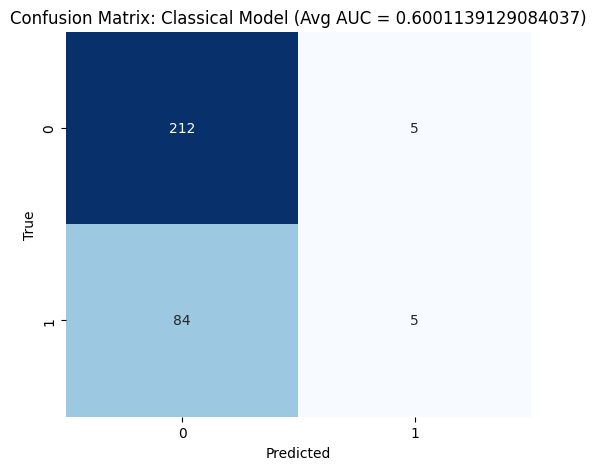

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 5

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model_normal = NormalModel(freeze=True, num_classes=2)
model_hybrid = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 41:


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7245, Training Accuracy: 56.15%, Training AUROC: 0.5027
Validation Loss: 0.6748, Validation Accuracy: 60.53%, Validation AUROC: 0.4983
Epoch [2/100]
Training Loss: 0.6958, Training Accuracy: 64.88%, Training AUROC: 0.4892
Validation Loss: 0.6865, Validation Accuracy: 53.95%, Validation AUROC: 0.5017
Epoch [3/100]
Training Loss: 0.6789, Training Accuracy: 67.02%, Training AUROC: 0.5102
Validation Loss: 0.6900, Validation Accuracy: 50.66%, Validation AUROC: 0.5206
Epoch [4/100]
Training Loss: 0.6756, Training Accuracy: 65.95%, Training AUROC: 0.4944
Validation Loss: 0.6869, Validation Accuracy: 54.61%, Validation AUROC: 0.5250
Epoch [5/100]
Training Loss: 0.6594, Training Accuracy: 68.27%, Training AUROC: 0.5176
Validation Loss: 0.6890, Validation Accuracy: 50.00%, Validation AUROC: 0.5250
Epoch [6/100]
Training Loss: 0.6723, Training Accuracy: 67.20%, Training AUROC: 0.5115
Validation Loss: 0.6880, Validation Accuracy: 53.95%, Validation AUROC: 0.5189
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.8260, Training Accuracy: 40.29%, Training AUROC: 0.4551
Validation Loss: 0.6931, Validation Accuracy: 49.34%, Validation AUROC: 0.4505
Epoch [2/100]
Training Loss: 0.6890, Training Accuracy: 57.93%, Training AUROC: 0.4657
Validation Loss: 0.6866, Validation Accuracy: 53.95%, Validation AUROC: 0.4743
Epoch [3/100]
Training Loss: 0.6321, Training Accuracy: 68.27%, Training AUROC: 0.4333
Validation Loss: 0.6648, Validation Accuracy: 63.16%, Validation AUROC: 0.4670
Epoch [4/100]
Training Loss: 0.6085, Training Accuracy: 70.94%, Training AUROC: 0.4923
Validation Loss: 0.6535, Validation Accuracy: 69.08%, Validation AUROC: 0.4716
Epoch [5/100]
Training Loss: 0.6080, Training Accuracy: 70.94%, Training AUROC: 0.4722
Validation Loss: 0.6516, Validation Accuracy: 69.74%, Validation AUROC: 0.4621
Epoch [6/100]
Training Loss: 0.6039, Training Accuracy: 70.94%, Training AUROC: 0.4927
Validation Loss: 0.6429, Validation Accuracy: 71.05%, Validation AUROC: 0.4661
Epoc

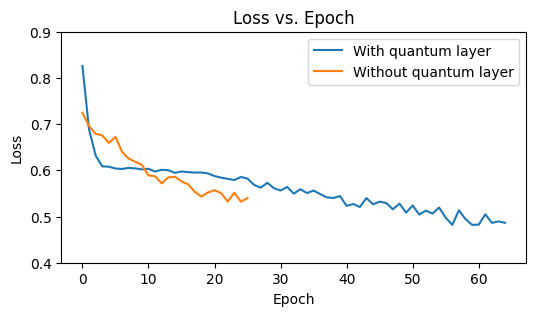

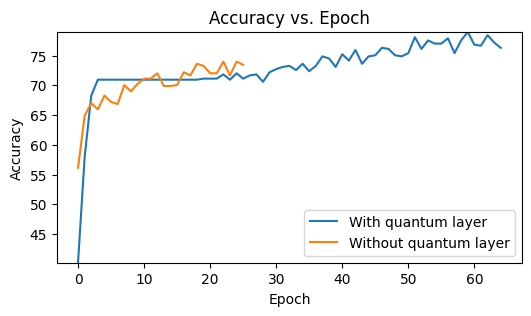

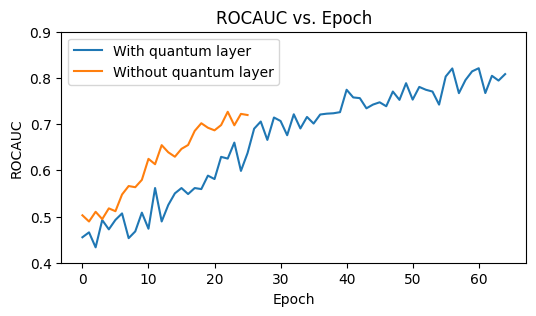

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

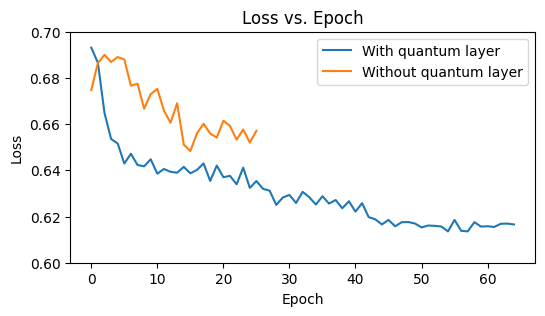

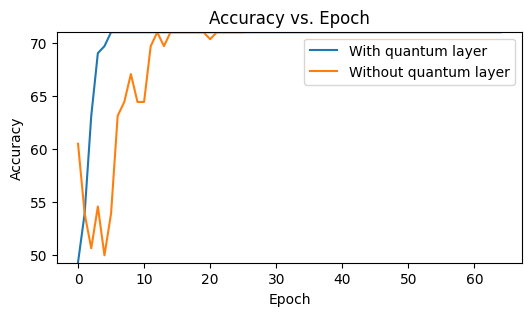

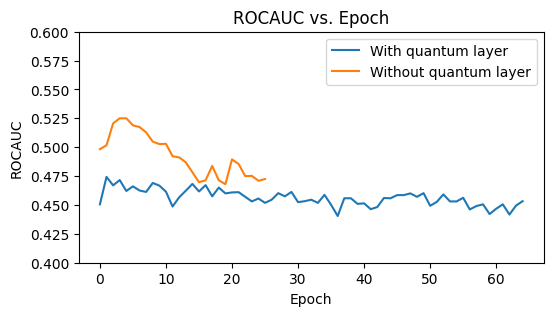

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-G1020_models/normal_model_19.pth")
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-G1020_models/quantum_hybrid_model_19.pth")

<ipython-input-24-9780e79bb754>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-G10

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


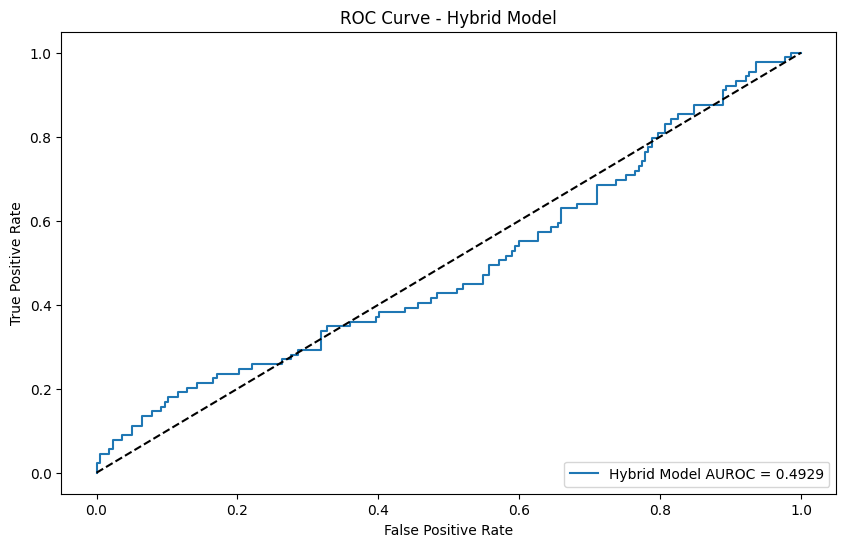

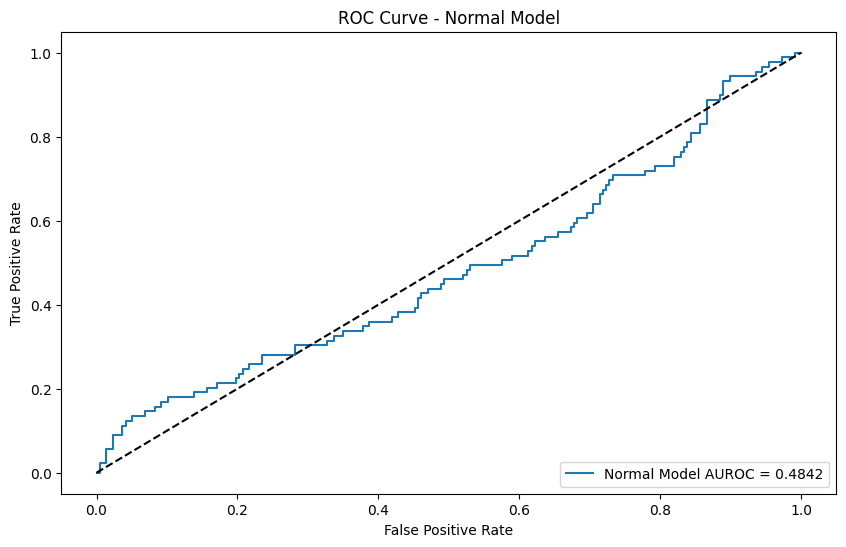


Hybrid Model Metrics:
Accuracy: 0.7092
F1 Score: 0.5885
Precision: 0.0000
Recall: 0.0000
AUROC: 0.49288044322477087

Normal Model Metrics:
Accuracy: 0.7092
F1 Score: 0.5885
Precision: 0.0000
Recall: 0.0000
AUROC: 0.4841816393103091 



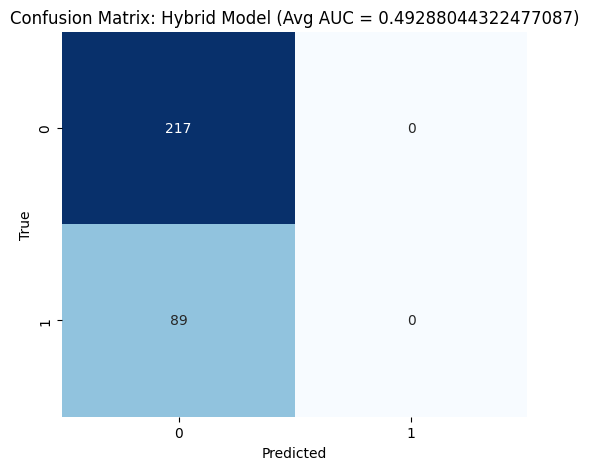

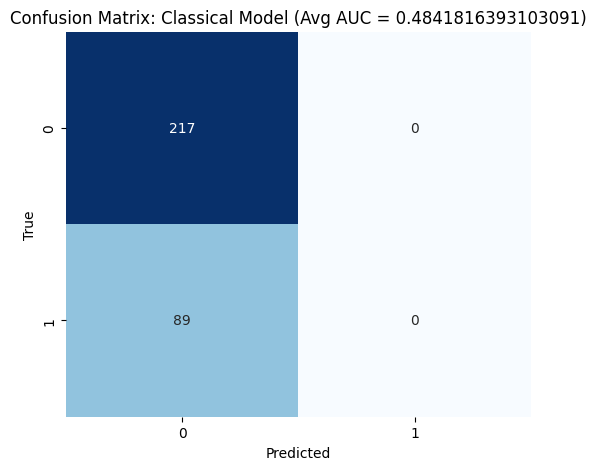

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)